# Clustering Insurance Companies Based on Claim Payments to the Hospital in 5 Years (Clustering Timeseries)

### Import Libraries

In [1]:
!pip install tslearn # install tslearn

In [2]:
import numpy as np
import pandas as pd
import math
import os

import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "svg"

from copy import deepcopy

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from tslearn.clustering import TimeSeriesKMeans, silhouette_score

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

The datasets consist of 5 years data from 2018 - 2022

In [3]:
# set directory path
dir_path = "./"

file_path = []
for file in os.listdir(dir_path):
  if '.xlsx' in file:
    file_path.append(file)
file_path = sorted(file_path)

file_path

['Revenue Per Payer  2018.xlsx',
 'Revenue Per Payer  2019.xlsx',
 'Revenue Per Payer  2020.xlsx',
 'Revenue Per Payer  2021.xlsx',
 'Revenue Per Payer  2022.xlsx']

Each dataset consists of the following features:
* Payer : Insurance company name
* Emergency: Insurance company claim payment amount for Emergency
* Health Checkup: Insurance company claim payment amount for Health Checkup
* Inpatient: Insurance company claim payment amount for Inpatient
* Outpatient: Insurance company claim payment amount for Outpatient

In [4]:
list_data = [] # initiate empty list

for file in file_path:
  dataset = pd.read_excel(dir_path + "/" + file)
  list_data.append(dataset)

# overview of dataset 2018
list_data[0]

,Payer,Emergency,Health Checkup,Inpatient,Outpatient
0,"BIOMEDILAB KLINIK, PT",2.766600e+06,2.650000e+06,2.875250e+06,2.806350e+06
1,"PLN (PERSERO) DISTRIBUSI JAWA TIMUR, PT",4.940846e+06,4.891373e+06,4.945633e+06,4.787641e+06
2,"PLN UIP MALUKU, PT",4.094383e+06,3.944746e+06,6.614930e+06,1.124925e+06
3,"ARTA BOGA CEMERLANG, PT",2.274750e+06,2.274750e+06,2.297498e+06,2.297498e+06
4,"LIPPO GENERAL INSURANCE, PT - MEARES SOPUTAN ...",9.056901e+06,1.864410e+08,3.359739e+08,2.142922e+08
...,...,...,...,...,...
214,"SIG ASIA , PT",2.040600e+07,1.900000e+07,2.038700e+07,1.939900e+07
215,"TELKOMSEL, PT - ASURANSI SINAR MAS, PT",2.606567e+06,6.691400e+06,1.061754e+07,6.850089e+06
216,TPA - ASO TIRTA,4.554586e+07,4.597011e+07,4.545495e+07,4.690951e+07
217,"WASKITA KARYA (PERSERO), PT",6.850089e+06,6.850089e+06,6.850089e+06,6.850089e+06


### Data Preprocessing

Given our datasets spans five years, each dataset will be transformed into several time-series format covering the period from 2018 to 2022. Every payer will be allocated four time-series datasets, each delineating four distinct features of hospital service types over the five-year interval. Notably, each time-series dataset will consist of a modest compilation of merely five datapoints. Subsequently, the following stages will be executed:

* Check the number of unique payer each dataset

In [5]:
i = 0
for item in list_data:
  print(f"Number of Payer {2018 + i}: {len(item.Payer.unique())}")
  i+=1

Number of Payer 2018: 219
Number of Payer 2019: 267
Number of Payer 2020: 297
Number of Payer 2021: 342
Number of Payer 2022: 418


Because the number of unique payers is different for each dataset, it can be concluded that there are some payers who have never made claim payments in certain years. For this reason, we will create a list of unique payer collections from all datasets.

In [6]:
list_payer = [] # initiate list of payer

for data in list_data:
  for payer in data.Payer.unique():
    if payer not in list_payer:
      list_payer.append(payer)
print(f"Number of Unique Payer All Dateset: {len(list_payer)}")
print("\n")
print("List Example: \n")
list_payer[0:30]

Number of Unique Payer All Dateset: 735


List Example: 



['BIOMEDILAB KLINIK, PT',
 'PLN (PERSERO) DISTRIBUSI JAWA TIMUR, PT',
 'PLN UIP MALUKU, PT',
 ' ARTA BOGA CEMERLANG, PT',
 ' LIPPO GENERAL INSURANCE, PT - MEARES SOPUTAN MINING (MSM), PT',
 ' LIPPO GENERAL INSURANCE, PT - NEWCREST HALMAHERA MINING (NHM), PT',
 ' LIPPO GENERAL INSURANCE, PT - TIRTA INVESTAMA (AQUA DANONE), PT',
 ' MATAHARI PUTRA PRIMA TBK, PT (TENANT)',
 ' PLN PERSERO, PT',
 'KARTIKA BINA MEDIKATAMA, PT - REDPATH INDONESIA, PT',
 '  CHUBB GENERAL INSURANCE INDONESIA (CHUBB) - CYNERGY CARE',
 ' *BNI LIFE*',
 ' A.J INHEALTH INDONESIA, PT (GOLD)',
 ' AA INTERNATIONAL INDONESIA, PT',
 ' AAI, PT - KAWAN LAMA GROUP',
 ' ADIRA MEDICILLIN INSURANCE',
 ' ADM. MEDIKA, PT - ANGKASA PURA I, PT',
 ' ADM-ASKRIDA',
 ' ADM-ASURANSI SOMPO JAPAN NIPPONKOA INDONESIA',
 ' ADM-HANWHA LIFE',
 ' ADM-MANDIRI INHEALTH (INDEMNITY)',
 ' ADM-PETROGAS (BASIN) LIMITED',
 ' ADM-PT FWD LIFE INDONESIA',
 ' AGRICON, PT',
 ' AIA FINANCIAL (PES-CALON NASABAH)',
 ' AIA FINANCIAL INDONESIA ',
 ' AJ CENTRAL 

There are 735 unique payers in the dataset. However, if we examine it further, there are several payers who have several similar first names or entities (*AIA FINANCIAL*, *LIPPO GENERAL INSURANCE*, etc). For now we assume that all payers identified are 735 different entities.

* Make timeseries dataset for all payers (2018 - 2022)

Create a collection of timeseries list for each unique payer.

In [7]:
table_ts = [] # initiate timeseries list

for payer in list_payer:
  ts = pd.DataFrame({
      "Year": range(2018,2023),
  })
  ts["Emergency"] = 0
  ts["Health Checkup"] = 0
  ts["Inpatient"] = 0
  ts["Outpatient"] = 0
  ts.Year = pd.to_datetime(ts.Year, format='%Y').dt.year

  for i in range(len(list_data)):
    for item in ts.drop(["Year"],axis=1).columns:
      if payer in list_data[i]["Payer"].unique():
        ts[item][i] = list_data[i][item][list(np.where(list_data[i]["Payer"] == payer)[0])].sum()

  ts["Total"] = ts["Emergency"] + ts["Health Checkup"] + ts["Inpatient"] + ts["Outpatient"]
  ts = ts.set_index('Year') # set year to be index
  table_ts.append([ts, payer])

In [8]:
# check random timeseries

table_ts[0:10]

[[      Emergency  Health Checkup  Inpatient  Outpatient     Total
  Year                                                            
  2018    2766600         2650000    2875250     2806350  11098200
  2019    1436400         1400000    1523200     1423800   5783400
  2020    1123600         1060000    1066360     1061060   4311020
  2021     854400          800000     804800      847200   3306400
  2022          0               0          0           0         0,
  'BIOMEDILAB KLINIK, PT'],
 [        Emergency  Health Checkup    Inpatient   Outpatient         Total
  Year                                                                     
  2018  4940845.512    4.891373e+06  4945633.153  4787641.000  1.956549e+07
  2019  1444957.000    1.512388e+06  1556218.689  1535989.291  6.049553e+06
  2020        0.000    0.000000e+00        0.000        0.000  0.000000e+00
  2021        0.000    0.000000e+00        0.000        0.000  0.000000e+00
  2022        0.000    0.000000e+00        0.0

* Filter timeseries data with one feature only.


In this section, we filter the total timeseries data.

In [9]:
# copy the table_ts

table_ts_total = deepcopy(table_ts)

In [10]:
# get total timeseries

for i in range(len(table_ts_total)):
  table_ts_total[i][0] = table_ts_total[i][0].loc[:,["Total"]]

In [11]:
table_ts_total[0:3]

[[         Total
  Year          
  2018  11098200
  2019   5783400
  2020   4311020
  2021   3306400
  2022         0,
  'BIOMEDILAB KLINIK, PT'],
 [             Total
  Year              
  2018  1.956549e+07
  2019  6.049553e+06
  2020  0.000000e+00
  2021  0.000000e+00
  2022  0.000000e+00,
  'PLN (PERSERO) DISTRIBUSI JAWA TIMUR, PT'],
 [             Total
  Year              
  2018  1.577898e+07
  2019  8.656597e+06
  2020  0.000000e+00
  2021  0.000000e+00
  2022  0.000000e+00,
  'PLN UIP MALUKU, PT']]

In [12]:
myseries_total = [series[0] for series in table_ts_total] # get timeseries only

## Training

K-Means is a clustering algorithm that partitions data points into K clusters based on similarity, with the objective of minimizing the variance within each cluster. In K-Means, the concept of distance plays a crucial role in determining how data points are assigned to clusters and how cluster centroids are updated.

The fundamental question arises: "How can we effectively measure the similarity between two sequences of time-series data?" Enter "Dynamic Time Warping" (DTW), a technique widely employed in the realm of speech recognition during the 1980s. DTW offers a solution by identifying the optimal alignment between two sets of observations over time, effectively "warping" the time dimension while imposing specific constraints.

Here, we use tslearn library to train kmeans using dynamic time warping.

In [13]:
# minmax scalling

for i in range(len(myseries_total)):
  scaler = MinMaxScaler()
  myseries_total[i] = MinMaxScaler().fit_transform(myseries_total[i])
  myseries_total[i] = myseries_total[i].reshape(len(myseries_total[i]))

To determine the initial number of clusters, we take the number of clusters as the root of the total timeseries.

In [14]:
cluster_count = math.ceil(math.sqrt(len(myseries_total)))
print(f"Cluster Count: {cluster_count}")

Cluster Count: 28


When calling the tslearn library for kmeans, because the distance measurement uses dynamic time warping, we apply "dtw" metric.

In [15]:
km = TimeSeriesKMeans(n_clusters=cluster_count, metric="dtw")
labels = km.fit_predict(myseries_total)
print(np.unique(labels))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27]


Let's plot the clustering results.

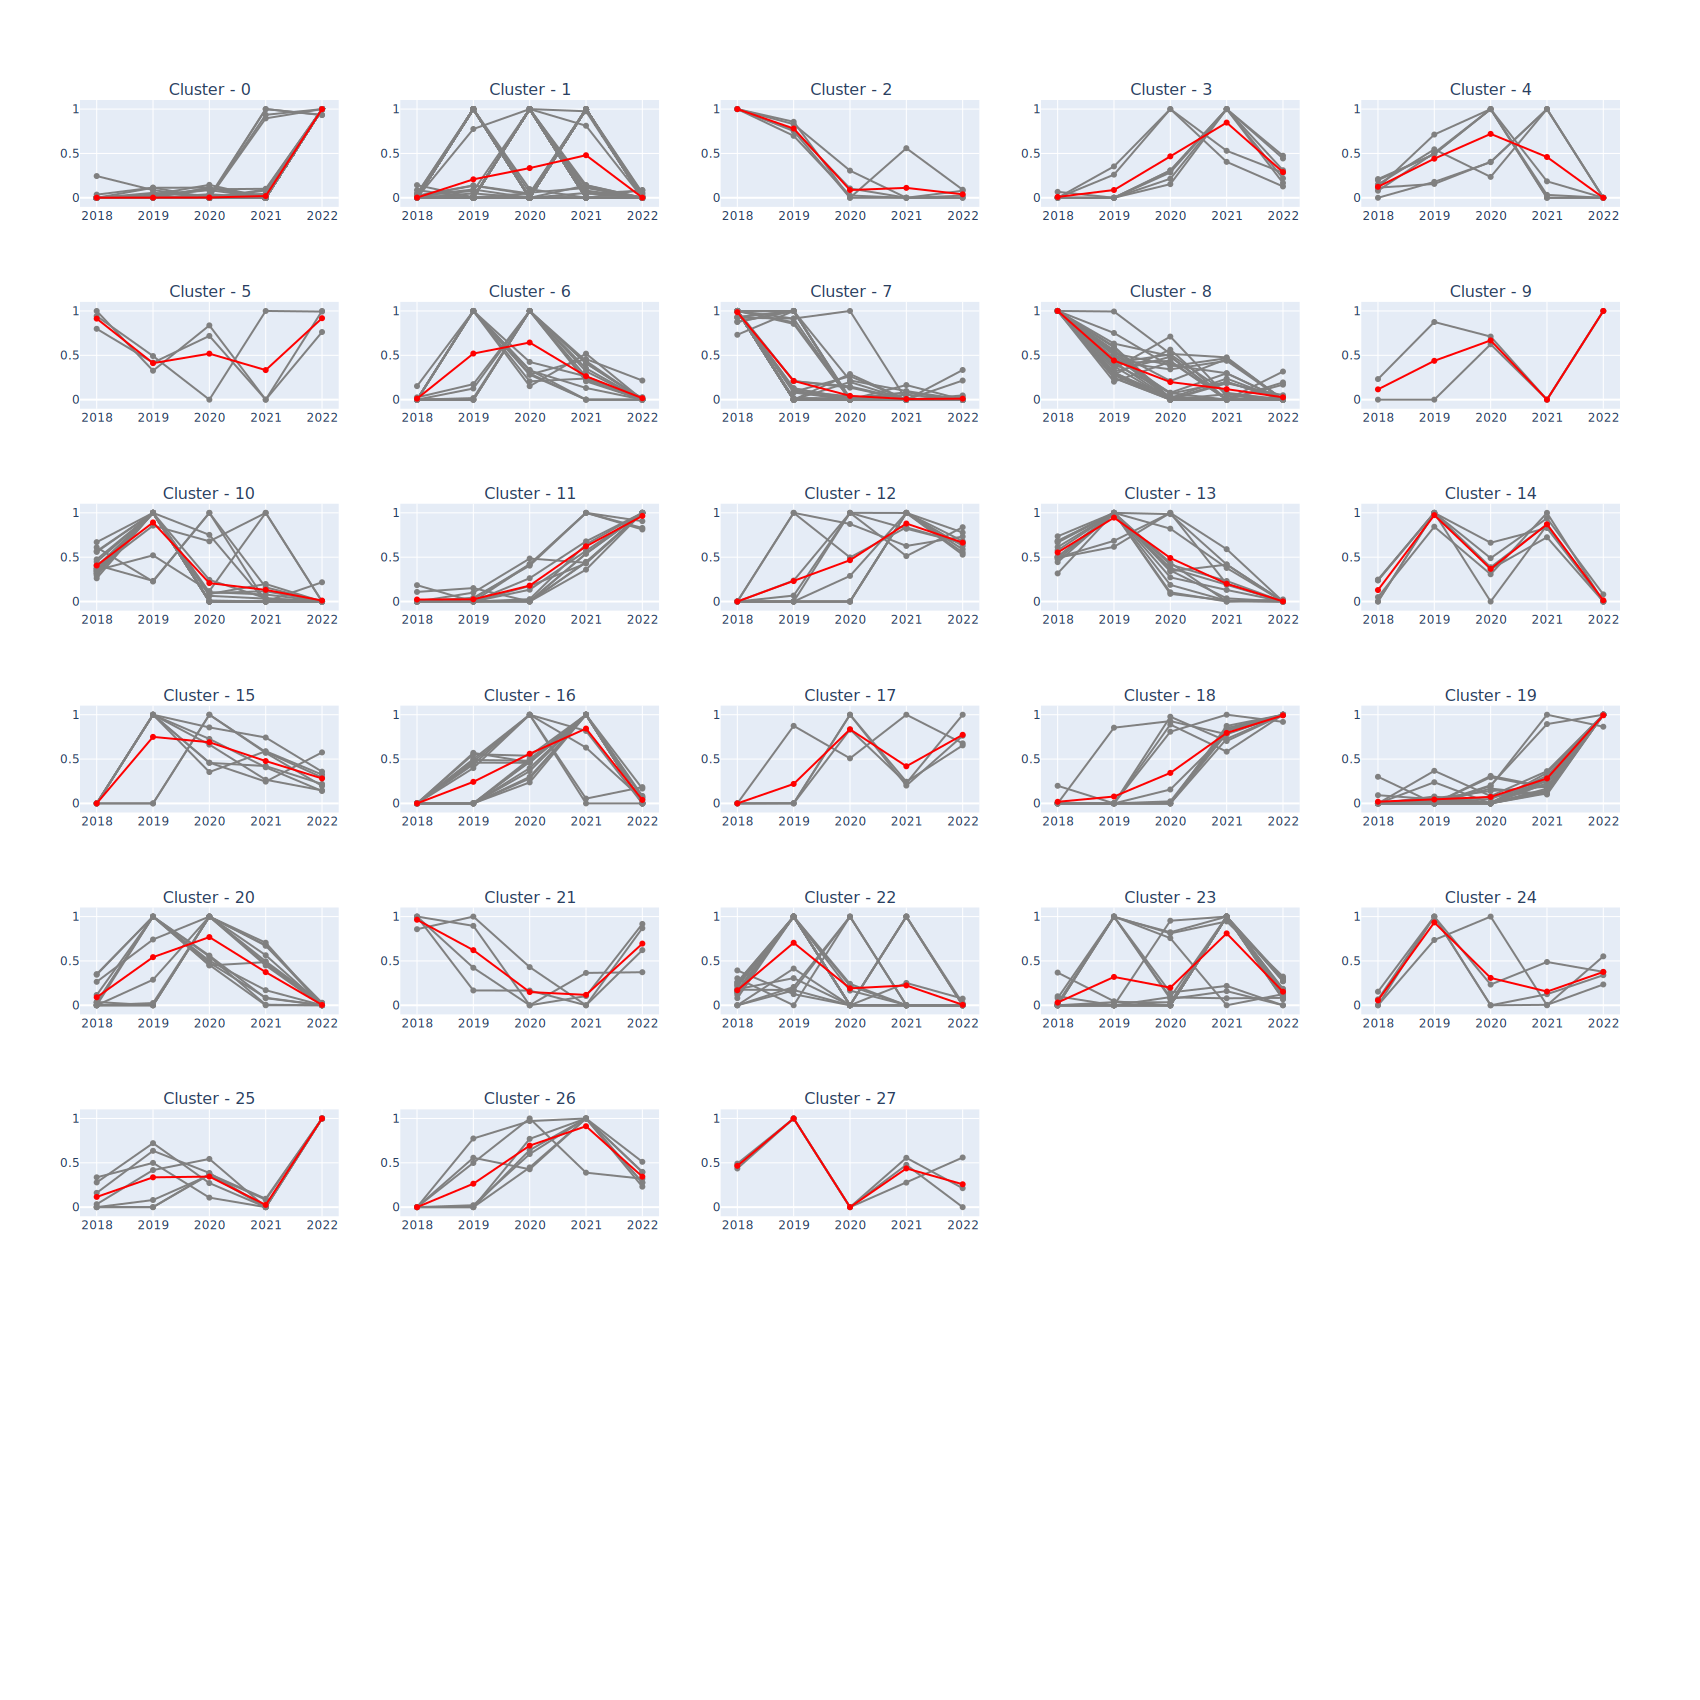

In [16]:
plot_count = math.ceil(math.sqrt(cluster_count))
som_x = som_y = math.ceil(math.sqrt(math.sqrt(len(myseries_total))))

fig = make_subplots(rows=8, cols=5, subplot_titles = [f"Cluster - {item}" for item in range(cluster_count)])

row_i = 1
column_j = 1

for label in set(labels):
  cluster = []
  for i in range(len(labels)):
    if (labels[i]==label):
      fig.add_trace(
          go.Scatter(x = list(range(2018,2023)), y = myseries_total[i],marker = {'color' : 'grey'}),
                    row=row_i,col=column_j
          )
      cluster.append(myseries_total[i])

  if len(cluster)>0:
    fig.add_trace(
          go.Scatter(x = list(range(2018,2023)), y = np.average(np.vstack(cluster),axis=0),marker = {'color' : 'red'}),
                    row=row_i,col=column_j)

  column_j+=1
  if column_j%plot_count==0:
    row_i+=1
    column_j=1
fig.update_layout(height=1700, width=1700, showlegend=False)
fig.show()


From the results of clustering 28 clusters, the image above is a plot of each cluster timeseries. The red line is a representative timeseries which is the average of all members of the timeseries cluster. Each cluster has the same pattern of value movements from 2018-2022.

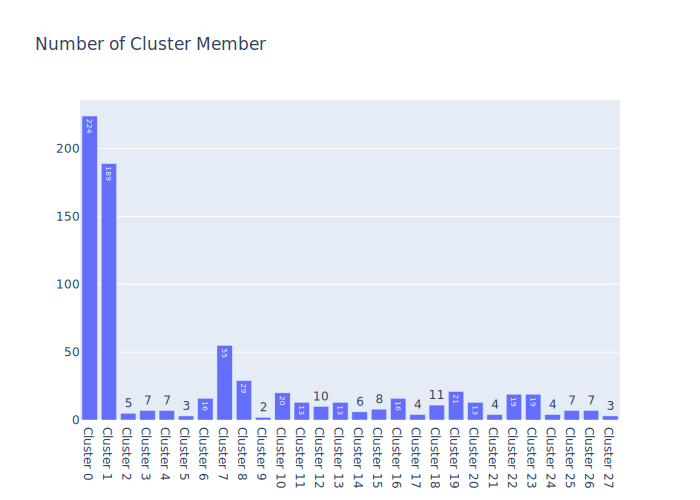

In [17]:
cluster_c = [len(labels[labels==i]) for i in range(cluster_count)]
cluster_n = ["Cluster "+str(i) for i in range(cluster_count)]

fig = go.Figure(data=[go.Bar(
    x=cluster_n,
    y=cluster_c,
    text=cluster_c,
    textposition='auto',
    )]).update_layout(
        title="Number of Cluster Member"
        )
fig.show()

Based on the plot results of the number of members of each cluster, it can be seen that the timeseries is dominated by 3 clusters, which are clusters 1, 2, and 3.

In [18]:
sil = []
kmax = 30

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
  km = TimeSeriesKMeans(n_clusters=k, metric="dtw")
  labels = km.fit_predict(myseries_total)
  sil.append(silhouette_score(myseries_total, labels, metric="dtw"))

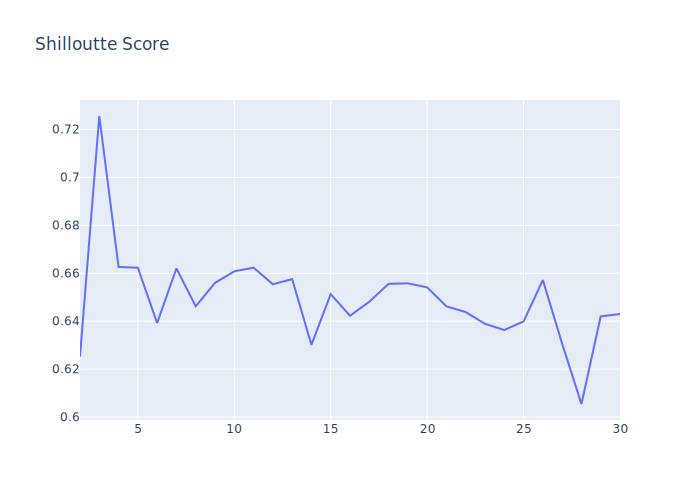

In [19]:
fig = go.Figure(data=[go.Scatter(
    x=list(range(2,kmax+1)),
    y=sil,
    text=sil,
    )]
    ).update_layout(title="Shilloutte Score")
fig.show()

From the shilloutte score plot it can be seen that the number of cluster 3 has the highest value. It can be said that the number of clusters 3 is the most optimal. So, lets train the total timeseries with 3 cluster.

In [20]:
cluster_count = 3
print(f"Cluster Count: {cluster_count}")

Cluster Count: 3


When calling the tslearn library for kmeans, because the distance measurement uses dynamic time warping, we apply "dtw" metric.

In [21]:
km = TimeSeriesKMeans(n_clusters=cluster_count, metric="dtw")
labels = km.fit_predict(myseries_total)
print(np.unique(labels))

[0 1 2]


Let's plot the clustering results.

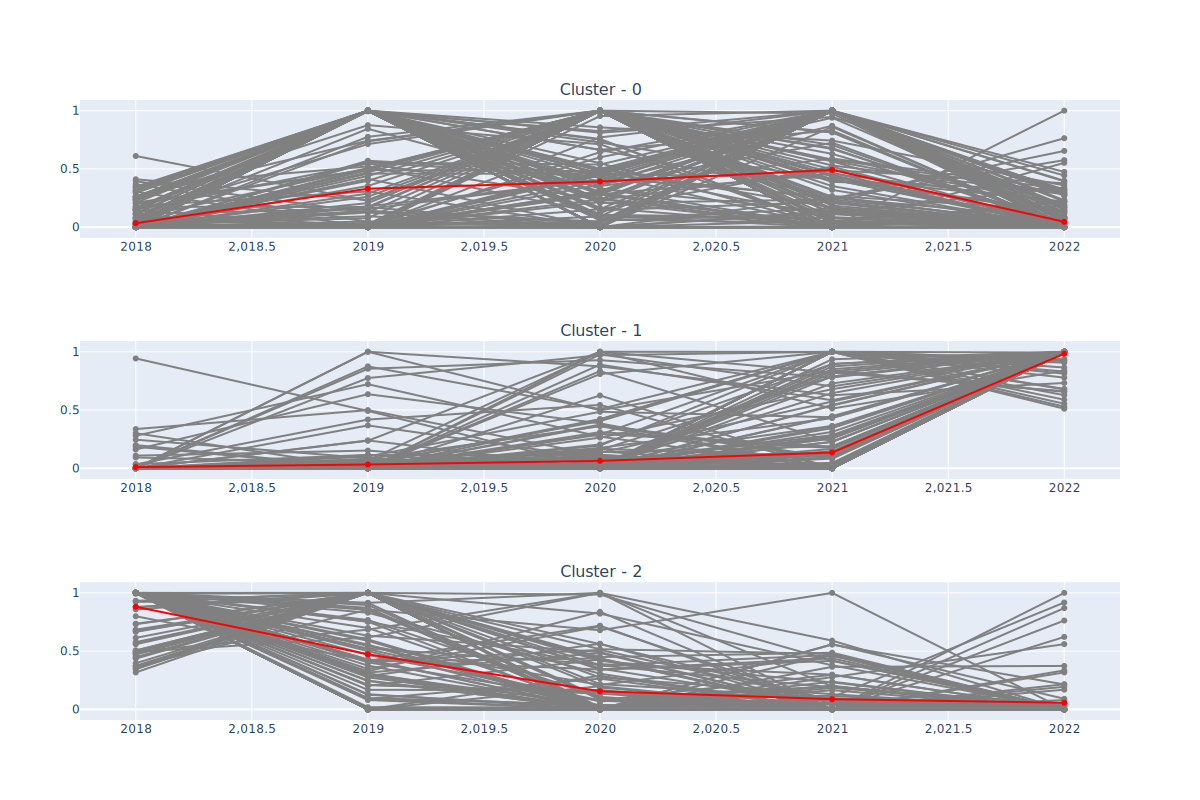

In [22]:
plot_count = math.ceil(math.sqrt(cluster_count))
som_x = som_y = math.ceil(math.sqrt(math.sqrt(len(myseries_total))))

fig = make_subplots(rows=3, cols=1, subplot_titles = [f"Cluster - {item}" for item in range(cluster_count)])

row_i = 1
column_j = 1

for label in set(labels):
  cluster = []
  for i in range(len(labels)):
    if (labels[i]==label):
      fig.add_trace(
          go.Scatter(x = list(range(2018,2023)), y = myseries_total[i],marker = {'color' : 'grey'}),
                    row=row_i,col=column_j
          )
      cluster.append(myseries_total[i])

  if len(cluster)>0:
    fig.add_trace(
          go.Scatter(x = list(range(2018,2023)), y = np.average(np.vstack(cluster),axis=0),marker = {'color' : 'red'}),
                    row=row_i,col=column_j)

  column_j+=1
  if column_j%plot_count==0:
    row_i+=1
    column_j=1
fig.update_layout(height=800, width=1200, showlegend=False)
fig.show()

From the results of training the timeseries into 3 clusters. It can be seen that for cluster 0, it is the timeseries group which tends to have relatively low income from 2018-2021 and experiences a significant increase in 2022. For cluster 1, it is the timeseries group which tends to experience an increase from 2018-2021 but experienced a significant decrease in 2022. Lastly, cluster 2 is the timeseries group which made relatively high payments in 2018 but fell significantly in 2019 and did not experience a significant increase until 2022.

From the results of training the timeseries into 3 clusters. It can be seen that for cluster 0, it is the timeseries group which tends to have relatively low income from 2018-2021 and experiences a significant increase in 2022. For cluster 1, it is the timeseries group which tends to experience an increase from 2018-2021 but experienced a significant decrease in 2022. Lastly, cluster 2 is the timeseries group which made relatively high payments in 2018 but fell significantly in 2019 and did not experience a significant increase until 2022.